In [14]:
import os
import numpy as np
import matplotlib.pyplot as plt
import mne
import pickle
import seaborn as sns
import pandas as pd
from scipy import stats
from statannotations.Annotator import Annotator

plt.rcParams.update({'font.size': 12})

# PFI

In [5]:
# Load meg channel config
dataset_path = os.path.join('/',
                            'well',
                            'woolrich',
                            'projects',
                            'cichy118_cont',
                            'raw_data',
                            'subj01',
                            'MEG2_subj01_sess01_tsss_mc-3.fif')
raw = mne.io.read_raw_fif(dataset_path, preload=True)
chn_type = 'mag'
raw = raw.pick(chn_type)

Opening raw data file /well/woolrich/projects/cichy118_cont/raw_data/subj01/MEG2_subj01_sess01_tsss_mc-3.fif...


<ipython-input-5-901adaf23559>:10: RuntimeWarning: This filename (/well/woolrich/projects/cichy118_cont/raw_data/subj01/MEG2_subj01_sess01_tsss_mc-3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(dataset_path, preload=True)


    Range : 4930000 ... 5162999 =   4930.000 ...  5162.999 secs
Ready.
Reading 0 ... 232999  =      0.000 ...   232.999 secs...


In [6]:
# load gradient analysis results
path = os.path.join('..',
                    'results',
                    'cichy_epoched',
                    'all_noshuffle_wavenetclass_semb10_drop0.4',
                    'grads.npy')

grads = np.load(path)
pfi = np.abs(grads).transpose(0, 2, 1)
pfits = np.mean(pfi, axis=2)

# convolve pfits with summation kernel
kernel = np.ones(24) / 24

# use convolution which operates on last axis
pfits = np.apply_along_axis(lambda x: np.convolve(x, kernel, mode='same'), -1, pfits)

time_range = np.arange(-100, 924, 4)

In [16]:
pfits.shape

(10000, 256)

In [64]:
# load pfi data
path = os.path.join('..', 'results', 'cichy_epoched', 'all_noshuffle_wavenetclass_semb10_drop0.4', 'groupPFI',
                    'val_loss_PFIch4.npy')
pfi = np.load(open(path, 'rb'))
pfi = pfi[0, 0, 0] - pfi[:, :, 1:]

time_range = np.arange(-48, 872, 4)

Opening raw data file cichy_data/subj0/MEG2_subj01_sess01_tsss_mc-3.fif...
    Range : 4930000 ... 5162999 =   4930.000 ...  5162.999 secs
Ready.
Reading 0 ... 232999  =      0.000 ...   232.999 secs...


/var/folders/nv/wjmf18wd5_j38vg9v0cthl5h0000gn/T/ipykernel_2304/202119110.py:3: RuntimeWarning: This filename (cichy_data/subj0/MEG2_subj01_sess01_tsss_mc-3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(dataset_path, preload=True)


In [65]:
# PFIts
path = os.path.join('..', 'results', 'cichy_epoched', 'all_noshuffle_wavenetclass_semb10_drop0.4', 'groupPFI',
                    'val_loss_PFIts.npy')
pfits = np.load(open(path, 'rb'))
pfits = pfits[0, 0] - pfits

In [7]:
# times array
times = np.array([time_range for _ in range(pfi.shape[0])])
times = np.array([times.reshape(-1) for _ in range(pfi.shape[2])]).T
times = times.reshape(-1)

# channels array
pfi_pd = pfi.reshape(-1, pfi.shape[2])

# magnitudes for color hues
mags = np.abs(np.mean(pfi, axis=(0, 1)))
mags = np.array([mags/np.max(mags[:-1]) for _ in range(pfi_pd.shape[0])])
mags = mags.reshape(-1)

pfi_pd = pfi_pd.reshape(-1)

In [8]:
# put everything in a pd dataframe
pd_dict = {'Gradient magnitude': pfi_pd, 'Time (ms)': times, 'relative magnitude': mags, 'channels': ['individual']*mags.shape[0]}
pfi_pd = pd.DataFrame(pd_dict)

In [9]:
times = np.array([time_range for _ in range(pfits.shape[0])])
pfits_pd = pfits.reshape(-1)
times = times.reshape(-1)
mags_ts = [np.max(mags)] * times.shape[0]
channels = ['aggregate'] * times.shape[0]
inds = list(range(mags.shape[0], mags.shape[0]+times.shape[0]))
pfits_pd = pd.DataFrame({'Gradient magnitude': pfits_pd, 'Time (ms)': times, 'relative magnitude': mags_ts, 'channels': channels}, index=inds)
pfi_pd = pd.concat((pfi_pd, pfits_pd))

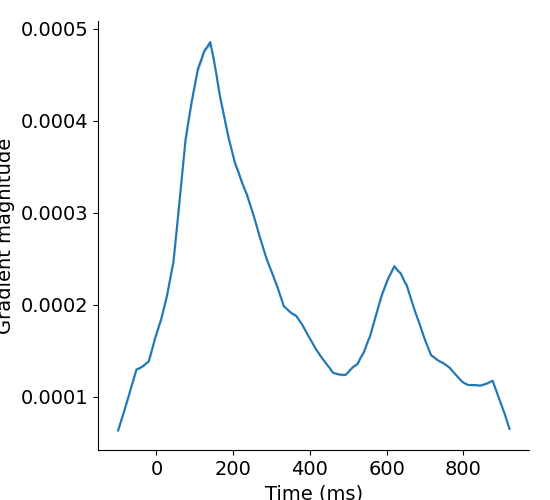

In [10]:
%matplotlib widget
pfi_plot = sns.relplot(
    data=pfits_pd, kind="line",
    x="Time (ms)", y="Gradient magnitude", hue='relative magnitude', n_boot=10, legend=None, aspect=1.1
)
#plt.savefig('/Users/ricsi/GoogleDrive/Projektek/The Brain Project/oxford/writings/neurips_figures/temporal_PFI.pdf', format='pdf')

In [25]:
pfi_pd

,Accuracy loss,Time (ms),relative magnitude,channels
0,0.000059,-100,0.198414,individual
1,0.000011,-100,0.264102,individual
2,0.000133,-100,0.284523,individual
3,0.000019,-100,0.211673,individual
4,0.000029,-100,0.216009,individual
...,...,...,...,...
783359995,0.000168,920,0.311056,individual
783359996,0.000429,920,0.256236,individual
783359997,0.000052,920,0.180380,individual
783359998,0.000256,920,0.226091,individual


In [26]:
%matplotlib widget
pfi_plot = sns.relplot(
    data=pfi_pd, kind="line", size='channels', style='channels', size_order=['aggregate', 'individual'],
    x="Time (ms)", y="Accuracy loss", hue='relative magnitude', n_boot=10, legend='brief', palette='Reds', aspect=2
)

handles, labels = plt.gca().get_legend_handles_labels()
pfi_plot._legend.remove()
plt.legend(handles[-3:], labels[-3:])

KeyboardInterrupt: 

In [10]:
plt.savefig('/Users/ricsi/GoogleDrive/Projektek/The Brain Project/oxford/writings/neurips_figures/channelwise_PFI.svg', format='svg')

# Accuracies

In [6]:
df = pd.read_csv('excel_data.txt', sep="\t", header=0)
df = df.stack().reset_index()
df = df.rename(columns={'level_0': 'subject', 'level_1': 'model', 0: 'Validation accuracy'})

model_type = []
for i in range(len(df)):
    if 'finetuned' in df['model'][i]:
        model_type.append('finetuned')
    elif 'emb' in df['model'][i]:
        model_type.append('group\nembedding')
    elif 'group' in df['model'][i]:
        model_type.append('group')
    else:
        model_type.append('subject')
df['model type'] = model_type

In [3]:
df[df['model']=='nonlin-group-emb']

,subject,model,Validation accuracy,model type
5,0,nonlin-group-emb,0.490662,group\nembedding
12,1,nonlin-group-emb,0.318117,group\nembedding
19,2,nonlin-group-emb,0.112696,group\nembedding
26,3,nonlin-group-emb,0.522857,group\nembedding
33,4,nonlin-group-emb,0.705128,group\nembedding
40,5,nonlin-group-emb,0.471510,group\nembedding
47,6,nonlin-group-emb,0.637269,group\nembedding
54,7,nonlin-group-emb,0.212554,group\nembedding
61,8,nonlin-group-emb,0.464950,group\nembedding
68,9,nonlin-group-emb,0.454416,group\nembedding


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

lin-subject vs. nonlin-subject: Wilcoxon test (paired samples), P_val:6.104e-04 Stat=5.000e+00
nonlin-group finetuned vs. nonlin-group-emb finetuned: Wilcoxon test (paired samples), P_val:3.052e-04 Stat=3.000e+00
nonlin-group-emb vs. nonlin-group-emb finetuned: Wilcoxon test (paired samples), P_val:6.104e-05 Stat=0.000e+00
nonlin-group vs. nonlin-group-emb: Wilcoxon test (paired samples), P_val:6.104e-05 Stat=0.000e+00
lin-subject vs. nonlin-group-emb: Wilcoxon test (paired samples), P_val:2.155e-02 Stat=2.000e+01
lin-subject vs. nonlin-group-emb finetuned: Wilcoxon test (paired samples), P_val:8.545e-04 Stat=6.000e+00


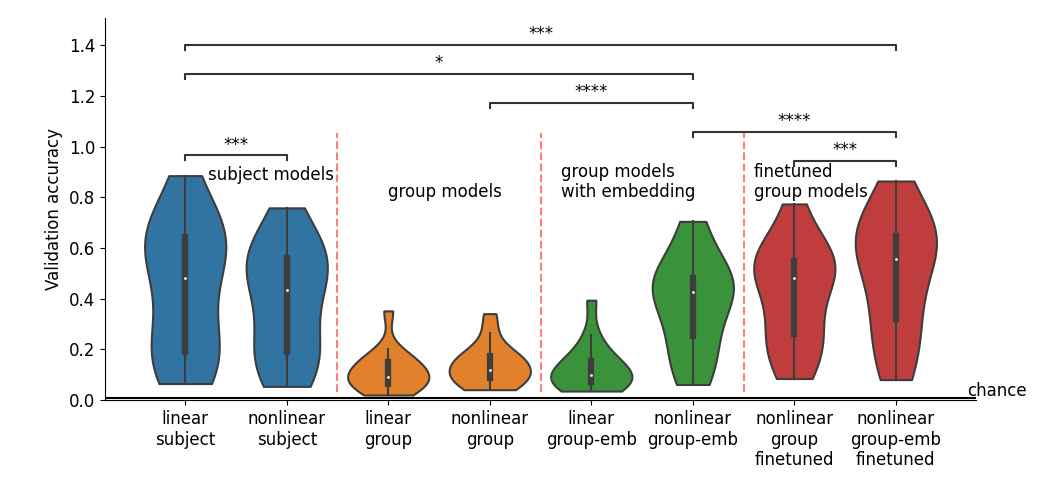

In [20]:
%matplotlib widget
'''
rows = df.loc[df['model type'] == 'subject']
g = sns.catplot(kind="violin", data=rows, cut=0, ci=None, scale='width', y='Validation accuracy', x='model')

ax = g.axes[0][0]
ax.axhline(0.008, ls='-', color='black', label='chance')
ax.axhline(0.33, ls='--', color='black', label='peak sliding accuracy')
plt.ylim(0, 1)
plt.legend()
plt.xlabel('')
plt.savefig('/Users/ricsi/GoogleDrive/Projektek/The Brain Project/oxford/writings/neurips_figures/subject_acc.svg', format='svg')
'''

plt.rcParams.update({'font.size': 12})
# Putting the parameters in a dictionary avoids code duplication
# since we use the same for `sns.boxplot` and `Annotator` calls
plot_params = {
    'kind':    'violin',
    'aspect':  2.1,
    'cut':     0,
    'ci':      None,
    'scale':   'area',
    'hue':     'model type',
    'dodge':   False,
    'data':    df,
    'x':       'model',
    'y':       'Validation accuracy',
    'legend':  None
}

g = sns.catplot(**plot_params)

ax = g.axes[0][0]
ax.axhline(0.008, ls='-', color='black', label='chance')
plt.ylim(0, 1)
plt.xlabel('')
plt.text(7.7,0.015,'chance')
plt.xticks(plt.xticks()[0], ['linear\nsubject',
                             'nonlinear\nsubject',
                             'linear\ngroup',
                             'nonlinear\ngroup',
                             'linear\ngroup-emb',
                             'nonlinear\ngroup-emb',
                             'nonlinear\ngroup\nfinetuned',
                             'nonlinear\ngroup-emb\nfinetuned'])

# add extra padding below plot and to the left of the y-axis
plt.subplots_adjust(bottom=0.2)
plt.subplots_adjust(left=0.1)

ymin = 0.02
ymax = 0.7
alpha = 0.5
dash = '--'
color = 'red'
ax.axvline(1.5, ymin, ymax, ls=dash, color=color, alpha=alpha)
ax.axvline(3.5, ymin, ymax, ls=dash, color=color, alpha=alpha)
ax.axvline(5.5, ymin, ymax, ls=dash, color=color, alpha=alpha)
plt.text(0.22,0.87,'subject models')
plt.text(2,0.8,'group models')
plt.text(3.7,0.8,'group models\nwith embedding')
plt.text(5.6,0.8,'finetuned\ngroup models')

# which pairs to computer stats on
pairs = [('lin-subject', 'nonlin-subject'),
         ('lin-subject', 'nonlin-group-emb'),
         ('lin-subject', 'nonlin-group-emb finetuned'),
         ('nonlin-group-emb', 'nonlin-group-emb finetuned'),
         ('nonlin-group finetuned', 'nonlin-group-emb finetuned'),
         ('nonlin-group-emb', 'nonlin-group')]

# Add statistics annotations
annotator = Annotator(ax, pairs, data=df, x='model', y='Validation accuracy')
annotator.configure(test='Wilcoxon', verbose=True, line_offset_to_group=10).apply_and_annotate()
e=0
plt.savefig('group_acc.pdf', format='pdf')

# Generalization to new subject

In [76]:
path = os.path.join('..', 'results', 'cichy_epoched', 'indiv_wavenetlinear_MNN', 'val_loss_general.npy')
accs = np.load(path)
train1 = [0.591525424, 0.303672316, 0.121468925, 0.680790966, 0.885593221, 0.662429377, 0.730225995, 0.159604517, 0.579096052, 0.627118642, 0.223163842, 0.151129942, 0.06497175, 0.483050848, 0.412429377]
accs = np.concatenate((accs, np.array(train1).reshape(-1, 1)), axis=1)
chance = [0.00847] * 15
accs = np.concatenate((np.array(chance).reshape(-1, 1), accs), axis=1)

In [77]:
accs_df = pd.DataFrame(accs)
accs_df = accs_df.stack().reset_index()
accs_df = accs_df.rename(columns={'level_0': 'subject', 'level_1': 'Training ratio', 0: 'Validation accuracy'})
accs_df['level'] = ['subject'] * len(accs_df)

In [159]:
accs_df

,level_0,level_1,0
0,0,0,0.008470
1,0,1,0.008475
2,0,2,0.013559
3,0,3,0.050847
4,0,4,0.116949
...,...,...,...
160,14,6,0.162429
161,14,7,0.213277
162,14,8,0.283898
163,14,9,0.331921


In [78]:
def create_df(accsg, level):
    # need to get actual subjects
    order = [10, 7, 3, 11, 8, 4, 12, 9, 5, 13, 1, 14, 2, 6, 0]
    accsg_df = pd.DataFrame(accsg[order, :])
    accsg_df = accsg_df.stack().reset_index()
    accsg_df = accsg_df.rename(columns={'level_0': 'subject', 'level_1': 'Training ratio', 0: 'Validation accuracy'})
    accsg_df['level'] = [level] * len(accsg_df)
    
    return accsg_df

In [79]:
path = os.path.join('..', 'results', 'cichy_epoched', 'all_wavenet_semb_general', 'val_loss_general.npy')
accsg = np.load(path)
group_emb = create_df(accsg, 'group-emb')

path = os.path.join('..', 'results', 'cichy_epoched', 'all_wavenet_general', 'val_loss_general.npy')
accsg = np.load(path)
group = create_df(accsg, 'group')

path = os.path.join('..', 'results', 'cichy_epoched', 'all_wavenet_semb_general', 'val_loss_subs_general.npy')
accsg = np.mean(np.load(path), axis=2)
group_emb_all = create_df(accsg, 'group-emb all')

path = os.path.join('..', 'results', 'cichy_epoched', 'all_wavenet_general', 'val_loss_subs_general.npy')
accsg = np.mean(np.load(path), axis=2)
group_all = create_df(accsg, 'group all')

In [80]:
df = pd.concat((accs_df, group_emb, group), ignore_index=True)

In [12]:
df[(df['subject'] == 14) & (df['level'] == 'group')]

,subject,Training ratio,Validation accuracy,level
319,14,0,0.043785,group
320,14,1,0.103107,group
321,14,2,0.152542,group
322,14,3,0.241525,group
323,14,4,0.210452,group
324,14,5,0.290960,group
325,14,6,0.314972,group
326,14,7,0.350282,group
327,14,8,0.411017,group
328,14,9,0.436441,group


In [19]:
df

,subject,Training ratio,Validation accuracy,level
0,0,0.0,0.008470,subject
1,0,0.1,0.008475,subject
2,0,0.2,0.013559,subject
3,0,0.3,0.050847,subject
4,0,0.4,0.116949,subject
...,...,...,...,...
325,14,0.6,0.314972,group
326,14,0.7,0.350282,group
327,14,0.8,0.411017,group
328,14,0.9,0.436441,group


In [11]:
df[df['subject'] == 14]

,subject,Training ratio,Validation accuracy,level
154,14,0,0.008470,subject
155,14,1,0.009887,subject
156,14,2,0.012712,subject
157,14,3,0.028249,subject
158,14,4,0.069209,subject
159,14,5,0.128531,subject
160,14,6,0.162429,subject
161,14,7,0.213277,subject
162,14,8,0.283898,subject
163,14,9,0.331921,subject


In [81]:
df['Training ratio'] = df['Training ratio'].astype(float)/10

In [29]:
p_values = []
for i in range(11):
    test1 = df['Validation accuracy'][(df['Training ratio'] == i) & (df['level'] == 'group all')]
    test2 = df['Validation accuracy'][(df['Training ratio'] == i) & (df['level'] == 'group-emb all')]
    
    p_values.append(stats.ttest_rel(test1, test2)[1] * 11)

In [30]:
p_values

[0.0060336492775827375,
 1.351510411629857,
 0.03169837884573075,
 4.3785466680206016,
 2.918205427079515,
 0.10703676926544689,
 0.020678270815296832,
 0.055122900986178884,
 0.11919219652472021,
 0.23726568570982257,
 nan]

In [83]:
%matplotlib widget
g = sns.relplot(
    data=df, kind="line", hue='level',
    x="Training ratio", y="Validation accuracy", n_boot=1000, aspect=1.2, ci=95
)
ax = g.axes[0][0]
plt.axhline(0.6, 0.02, 0.7, color='black')
plt.text(0,0.61,'group>subject (p<0.05)')
plt.ylim(0, 0.6)
plt.xlabel('Training set ratio')



ax.axhline(0.008, ls='-', color='black', label='chance')
ax.legend(loc='upper left')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [84]:
plt.savefig('/Users/ricsi/GoogleDrive/Projektek/The Brain Project/oxford/writings/neurips_figures/generalization.pdf', format='pdf')